In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.3.0


In [2]:
#HyperParameters
#Name of file to read from
Filename = "C:/Users/Annoy/Desktop/Spyder/Useful Code Snippets/Data/Historic BTC-USD data/BTC-USD_Megafile_01_31_2020-03_02_2020.csv"

#Batch Size
batch_size = 32
#Number of ticks network sees at a time
seq_len = 20

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [3]:
#Timevector layer
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [4]:
#Transformer Layers
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [5]:
#Load Data And Add Moving Average Logic

df = pd.read_csv(Filename, delimiter=',', usecols=['time', 'low','high','open','close','volume'])
# Replace 0 to avoid dividing by 0 later on
df.columns=['Time','Low','High','Open','Close','Volume']
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.tail()

# Apply moving average with a window of 10 days to all columns
df[['Low','High','Open','Close','Volume']] = df[['Low','High','Open','Close','Volume']].rolling(15).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()


,Time,Low,High,Open,Close,Volume
14,18:10:00,9354.891333,9370.600000,9359.490667,9363.804000,19.357475
15,18:15:00,9358.202000,9374.083333,9363.759333,9367.120667,18.771504
16,18:20:00,9361.793333,9378.017333,9367.075333,9370.817333,18.684556
17,18:25:00,9365.196000,9380.216667,9370.704000,9373.261333,17.780808
18,18:30:00,9366.740667,9382.748000,9373.148000,9374.880667,18.973802


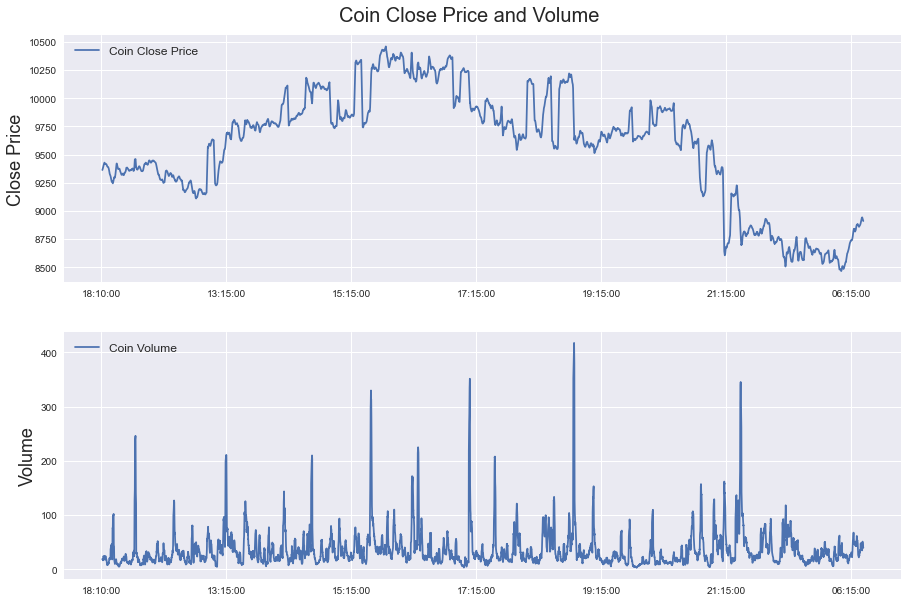

In [6]:
#Moving Average: plot relevant data
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Coin Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Coin Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Time'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Coin Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Time'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [7]:
#Moving Average, calculate percentage change for columns
df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Time'], inplace=True)
df_val.drop(columns=['Time'], inplace=True)
df_test.drop(columns=['Time'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (7130, 5)
Validation data shape: (891, 5)
Test data shape: (891, 5)


,Low,High,Open,Close,Volume
15,0.648442,0.650209,0.658566,0.648472,0.186673
16,0.651401,0.654959,0.648465,0.652479,0.193717
17,0.649390,0.636615,0.651760,0.639219,0.181701
18,0.629721,0.640116,0.639220,0.630496,0.213423
19,0.624993,0.626438,0.630108,0.629774,0.198115


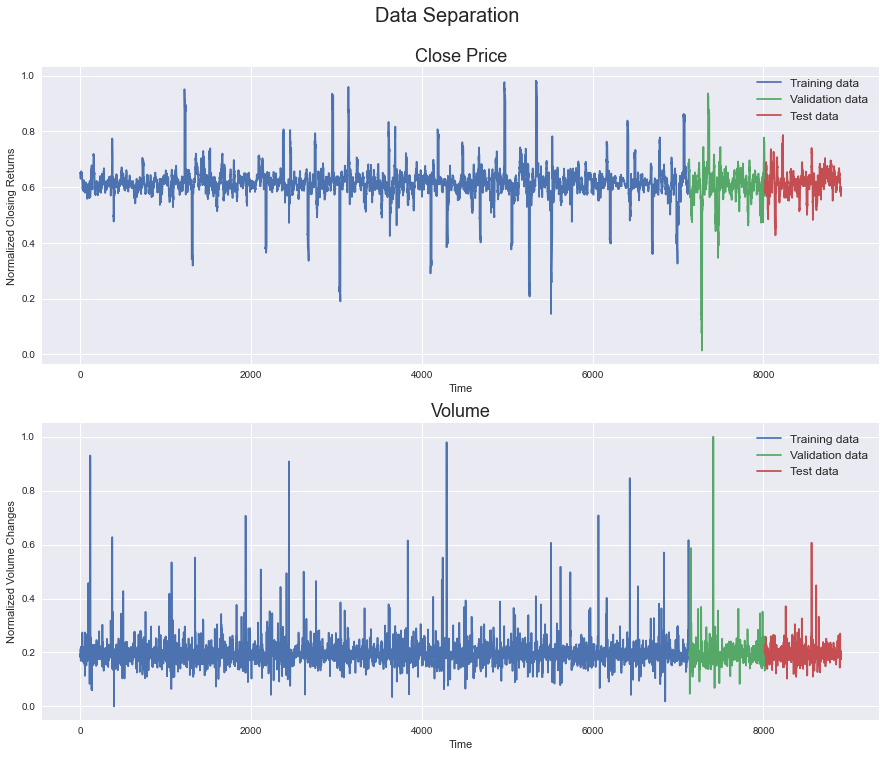

In [8]:
#Moving Average, replot close and volume
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [9]:
#Moving Average: split data into train, validation, and test set
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7110, 20, 5) (7110,)
(871, 20, 5) (871,)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 20, 2)        80          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20, 7)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 20, 7)        99114       concatenate[0][0]     

Epoch 14/40
223/223 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0324 - mape: 5.4935
Epoch 00014: val_loss improved from 0.00174 to 0.00172, saving model to C:/Users/Annoy/Desktop/Spyder/Useful Code Snippets/Models/PredictiveModels\Transformer+TimeEmbedding.hdf5
223/223 [==============================] - 72s 322ms/step - loss: 0.0020 - mae: 0.0324 - mape: 5.4935 - val_loss: 0.0017 - val_mae: 0.0243 - val_mape: 9.9289
Epoch 15/40
223/223 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0307 - mape: 5.2132
Epoch 00015: val_loss did not improve from 0.00172
223/223 [==============================] - 73s 326ms/step - loss: 0.0018 - mae: 0.0307 - mape: 5.2132 - val_loss: 0.0021 - val_mae: 0.0325 - val_mape: 10.5921
Epoch 16/40
223/223 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0308 - mape: 5.1979
Epoch 00016: val_loss did not improve from 0.00172
223/223 [==============================] - 81s 362ms/step - loss: 0.0019 - mae: 0.

Epoch 39/40
223/223 [==============================] - ETA: 0s - loss: 8.7677e-04 - mae: 0.0184 - mape: 3.1723
Epoch 00039: val_loss did not improve from 0.00134
223/223 [==============================] - 73s 326ms/step - loss: 8.7677e-04 - mae: 0.0184 - mape: 3.1723 - val_loss: 0.0021 - val_mae: 0.0344 - val_mape: 10.2999
Epoch 40/40
223/223 [==============================] - ETA: 0s - loss: 8.8800e-04 - mae: 0.0184 - mape: 3.1716
Epoch 00040: val_loss did not improve from 0.00134
223/223 [==============================] - 79s 354ms/step - loss: 8.8800e-04 - mae: 0.0184 - mape: 3.1716 - val_loss: 0.0014 - val_mae: 0.0218 - val_mape: 6.7440
 
Evaluation metrics
Training Data - Loss: 0.0006, MAE: 0.0142, MAPE: 2.4601
Validation Data - Loss: 0.0013, MAE: 0.0214, MAPE: 6.9313
Test Data - Loss: 0.0004, MAE: 0.0147, MAPE: 2.4181


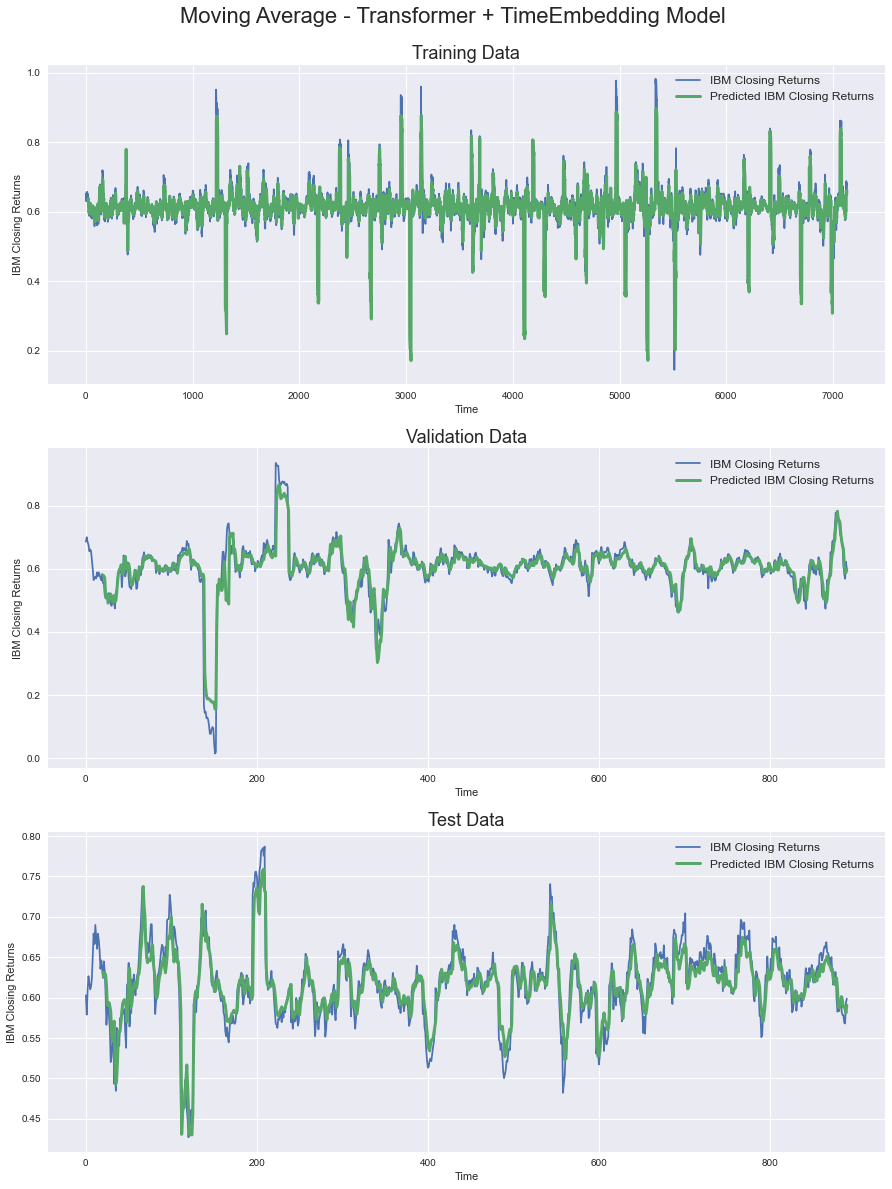

In [10]:
#Moving Average: Create model
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('C:/Users/Annoy/Desktop/Spyder/Useful Code Snippets/Models/PredictiveModels/Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=40, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('C:/Users/Annoy/Desktop/Spyder/Useful Code Snippets/Models/PredictiveModels/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Coin Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Coin Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Time')
ax11.set_ylabel('Coin Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Coin Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Coin Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Time')
ax21.set_ylabel('Coin Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Coin Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Coin Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Time')
ax31.set_ylabel('Coin Closing Returns')
ax31.legend(loc="best", fontsize=12)

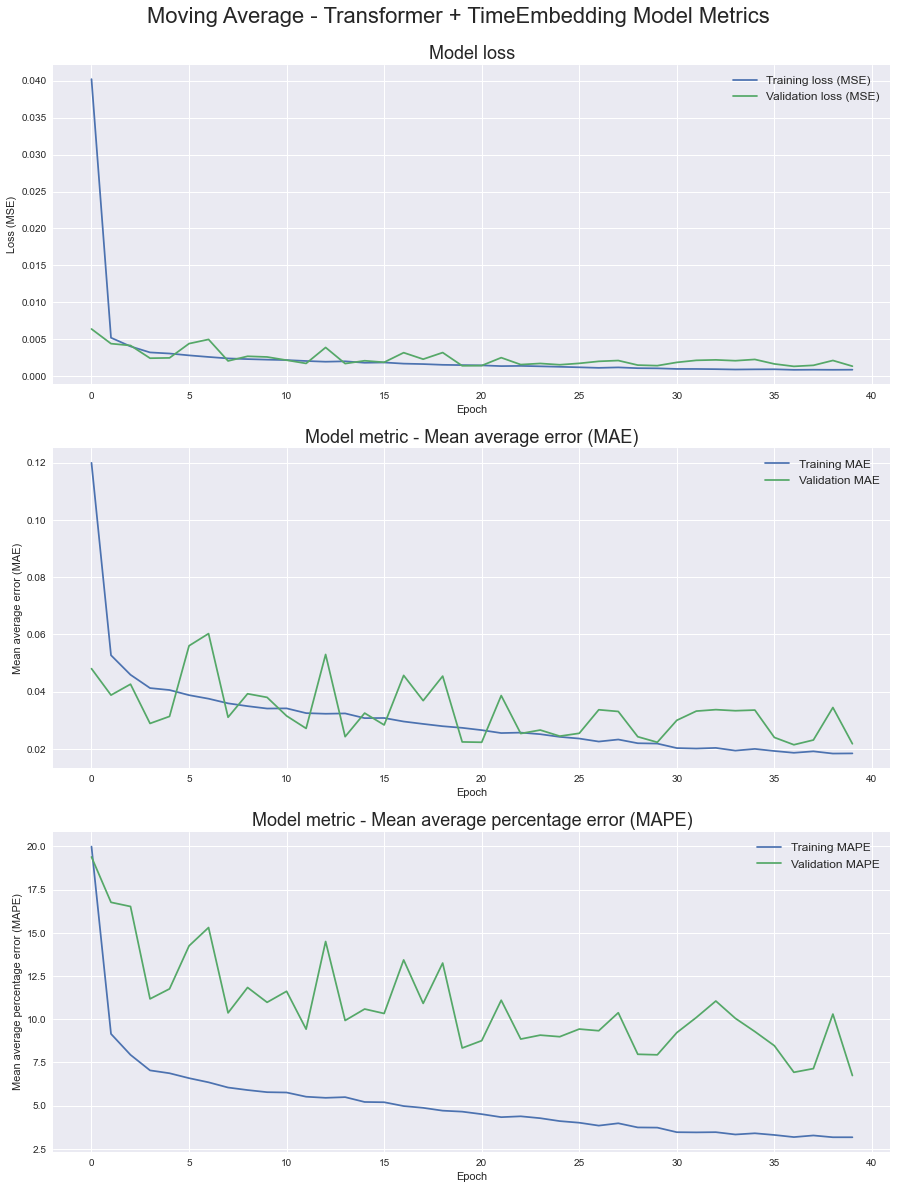

In [11]:
#Moving Average, model metrics
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [21]:
#Test on entirely different single day dataset
Filename = "C:/Users/Annoy/Desktop/Spyder/Useful Code Snippets/Data/Historic BTC-USD data/Historic_BTC-USD_Prices_05_11_2019.csv"
df = pd.read_csv(Filename, delimiter=',', usecols=['time', 'low','high','open','close','volume'])
# Replace 0 to avoid dividing by 0 later on
df.columns=['Time','Low','High','Open','Close','Volume']
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.tail()

# Apply moving average with a window of 10 days to all columns
df[['Low','High','Open','Close','Volume']] = df[['Low','High','Open','Close','Volume']].rolling(15).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

#Normalize
df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df.drop(columns=['Time'], inplace=True)
#Predict
train_pred = model.predict(df)
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot prediction
ax11 = fig.add_subplot(311)
ax11.plot(df.Close, label='Coin Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Coin Closing Returns')
ax11.set_title("Test set+ prediction", fontsize=18)
ax11.set_xlabel('Time')
ax11.set_ylabel('Coin Closing Returns')
ax11.legend(loc="best", fontsize=12)

ax21 = fig.add_subplot(312)
ax21.plot(df.Close, label='Coin Closing Returns')
ax21.set_title("Test Data", fontsize=18)
ax21.set_xlabel('Time')
ax21.set_ylabel('Coin Closing Returns')
ax21.legend(loc="best", fontsize=12)

ax31 = fig.add_subplot(313)
ax31.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Coin Closing Returns')
ax31.set_title("Prediction", fontsize=18)
ax31.set_xlabel('Time')
ax31.set_ylabel('Coin Closing Returns')
ax31.legend(loc="best", fontsize=12)

ValueError: in user code:

    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    <ipython-input-3-b95960fbd6b3>:31 call  *
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:1013 _slice_helper
        return strided_slice(
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:1186 strided_slice
        op = gen_array_ops.strided_slice(
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10347 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Annoy\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node functional_1/time2_vector_1/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=7, ellipsis_mask=0, end_mask=3, new_axis_mask=0, shrink_axis_mask=0](functional_1/Cast, functional_1/time2_vector_1/strided_slice/stack, functional_1/time2_vector_1/strided_slice/stack_1, functional_1/time2_vector_1/strided_slice/stack_2)' with input shapes: [?,5], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


,Time,Low,High,Open,Close,Volume
15,19:15:00,0.199160,0.095971,0.258989,0.046159,0.501375
16,19:20:00,0.000000,0.013015,0.052548,0.012849,0.642111
17,19:25:00,0.038098,0.049953,0.018117,0.056387,0.639161
18,19:30:00,0.108610,0.098172,0.056393,0.113120,0.632732
19,19:35:00,0.204987,0.133177,0.112260,0.198073,0.606088
